# 1. Imports

In [2]:
import pandas as pd
import numpy  as np
import pickle as pkl

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model    import RidgeClassifierCV, LogisticRegressionCV, LassoCV
from sklearn.metrics         import f1_score, ConfusionMatrixDisplay  
import xgboost as xgb 

from boruta import BorutaPy


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import Image


import warnings as wrg


from SRLib.Utilities import graph, modelSelect

# 2. Help Functions / Settings

In [56]:
sns.set( rc={'figure.figsize':( 35,10 )} )
#warings ignore
wrg.filterwarnings('ignore')

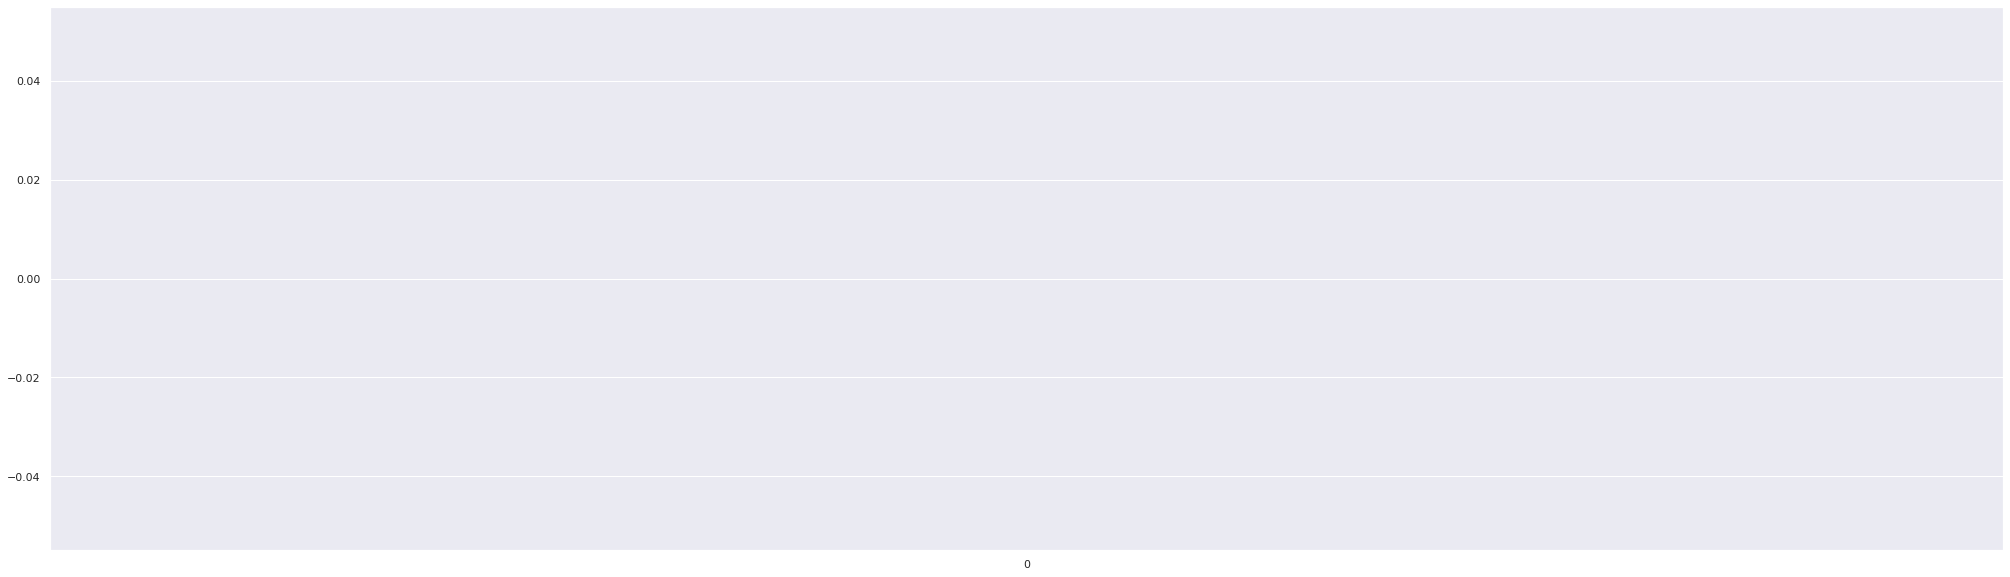

In [57]:
sns.barplot();

# 3. Data Load

In [58]:
data_raw = pd.read_csv( '../data/train.csv' )

## 3.1 Initial Transformation

- 0 = Male
- 1 = Female

In [59]:
data_raw['Sex']      = data_raw.Sex.apply( lambda x : 0 if x == 'male' else 1 )

# 4. EDA

## 4.1 General Analysis

### Dimensions

In [60]:
print( f'Dataset contendo {data_raw.shape[0]} linhas e {data_raw.shape[1]} colunas' )

Dataset contendo 891 linhas e 12 colunas


In [61]:
display( data_raw.drop( columns = 'PassengerId' ).describe().T )
display( data_raw.select_dtypes( exclude = ['int64', 'float64'] ).describe().T )

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Sex,891.0,0.352413,0.477990,0.00,0.0000,0.0000,1.0,1.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


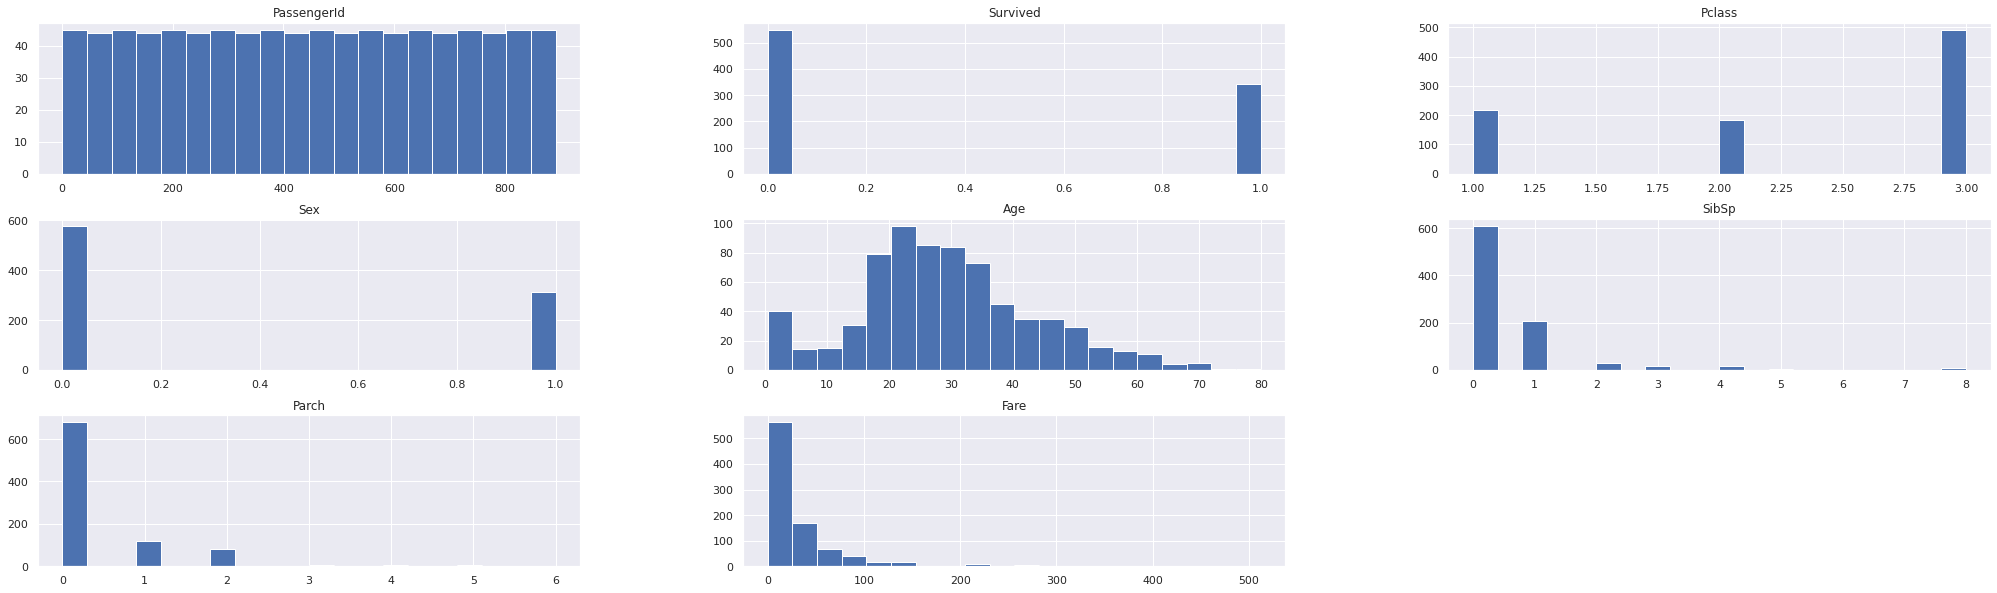

In [62]:
data_raw.hist( bins = 20 );

### CHECKPOINT

In [63]:
pkl.dump( data_raw, open( '../data/CP/data_raw.sav', 'wb' ) )

In [64]:
data_raw = pkl.load( open( '../data/CP/data_raw.sav', 'rb' ) )

### NA Values

In [65]:
data_raw.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 4.2 Mind Map

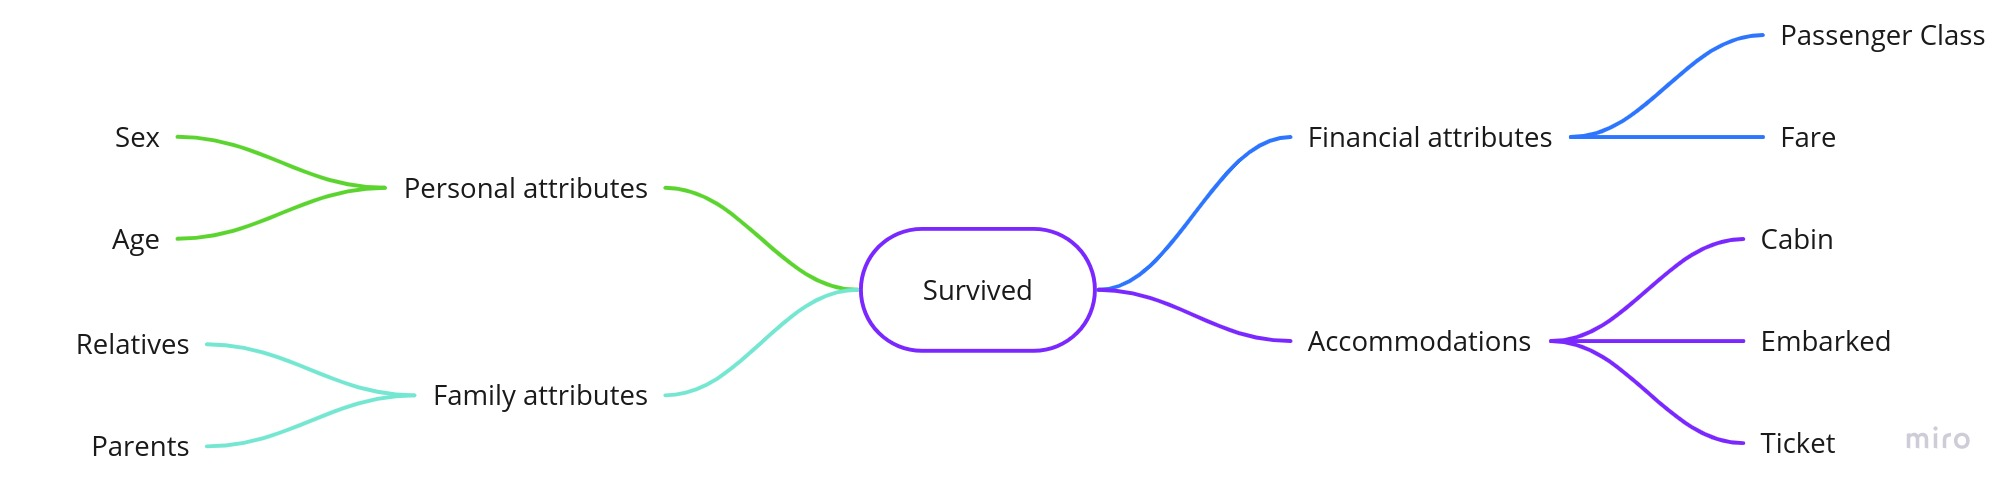

In [66]:
Image( '../img/Fraud Detect.jpg' )

## 4.3 Univariate Data Analysis

### Survived (Target)

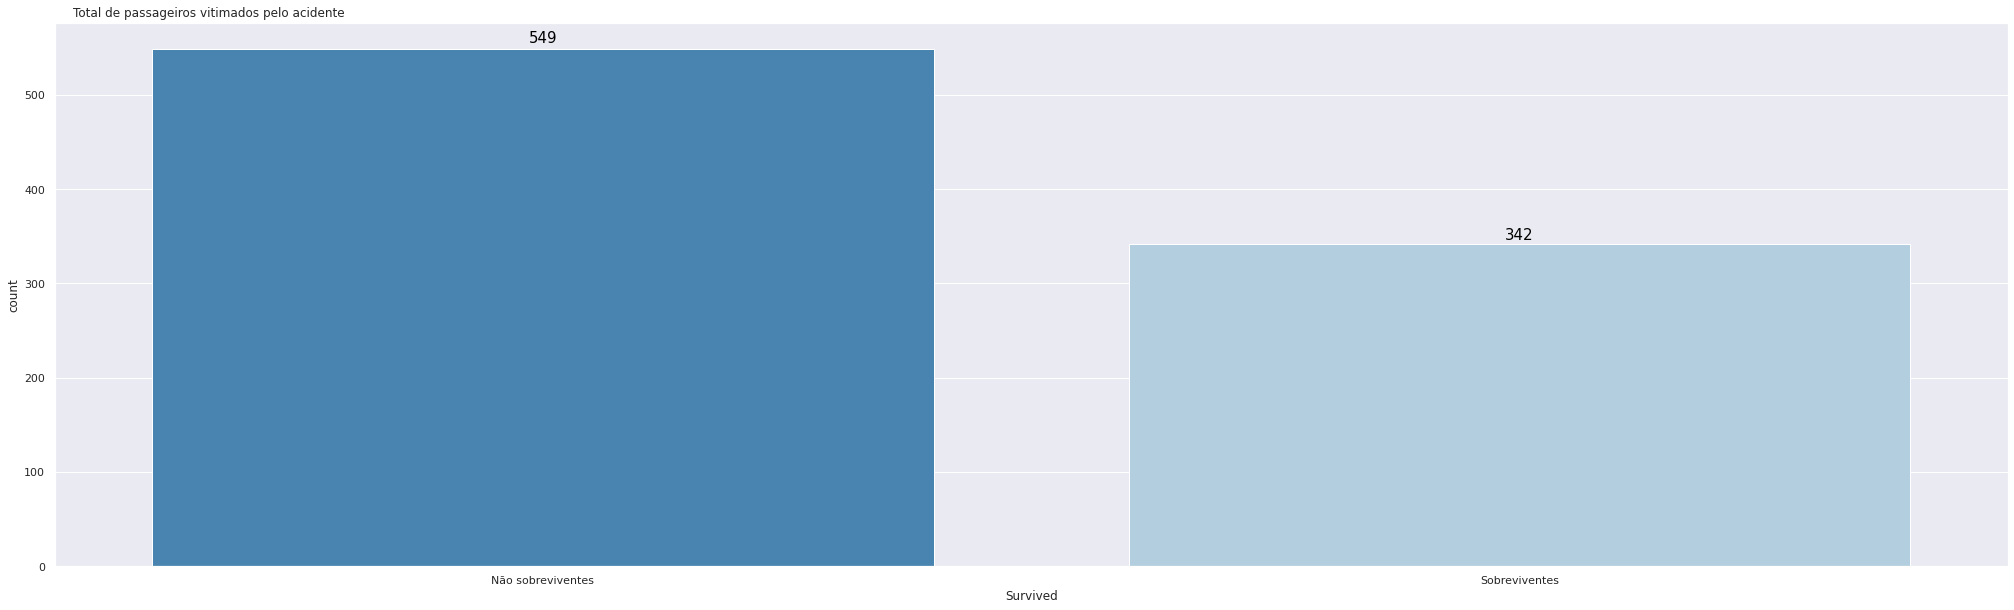

In [67]:
ax = sns.countplot( 
    data_raw.Survived,
    palette = 'Blues_r'
 )
graph.plot_values_vbar( ax )
ax.set_xticklabels( ['Não sobreviventes', 'Sobreviventes'] );
plt.title( "Total de passageiros vitimados pelo acidente", x = 0.079 );

### Name

- Será extraído apenas o titulo pessoal do nome para refinar a acurácia do modelo

### Age

- Para melhor performance dos dados, todas as idade menores que 1, serão arredondadas para 1
- Idades fracionadas serão arredondadas para baixo

In [68]:
data_raw.Age = data_raw.Age.apply( lambda x : 1 if x <= 1 else x  )

- Inicialmente, será inserido a média de idade por gênero onde os valores de idade estão faltantes

In [69]:
media_m = int( data_raw[data_raw.Sex == 0].Age.mean() )
media_f = int( data_raw[data_raw.Sex == 1].Age.mean() )
data_raw['Age'] = data_raw[['Age', 'Sex']].apply(
    lambda x :  media_m if ( np.isnan( x['Age'] ) ) & ( x['Sex'] == 0 ) else 
    media_f if ( np.isnan( x['Age'] ) ) & ( x['Sex'] == 1 ) 
    else x['Age'], axis = 1
)

In [70]:
data_raw.Age = data_raw.Age.apply( lambda x : int(x) )

### Cabin

- Como em sua grande maioria os dados de Cabine estão faltantes, optarei por exclui-la

In [71]:
data_raw.drop( columns = 'Cabin', inplace = True )

### Embarked

- Como são apenas 2 e não se pode extrair muitas informações a respeito das demais características, serão inseridos nos valores falntantes o valor que mais se repete no DF quanto a Embarked

In [72]:
data_raw.Embarked.fillna( 'S', inplace = True )

## 4.4 Bivariate data analysis

### Pclass x Survived

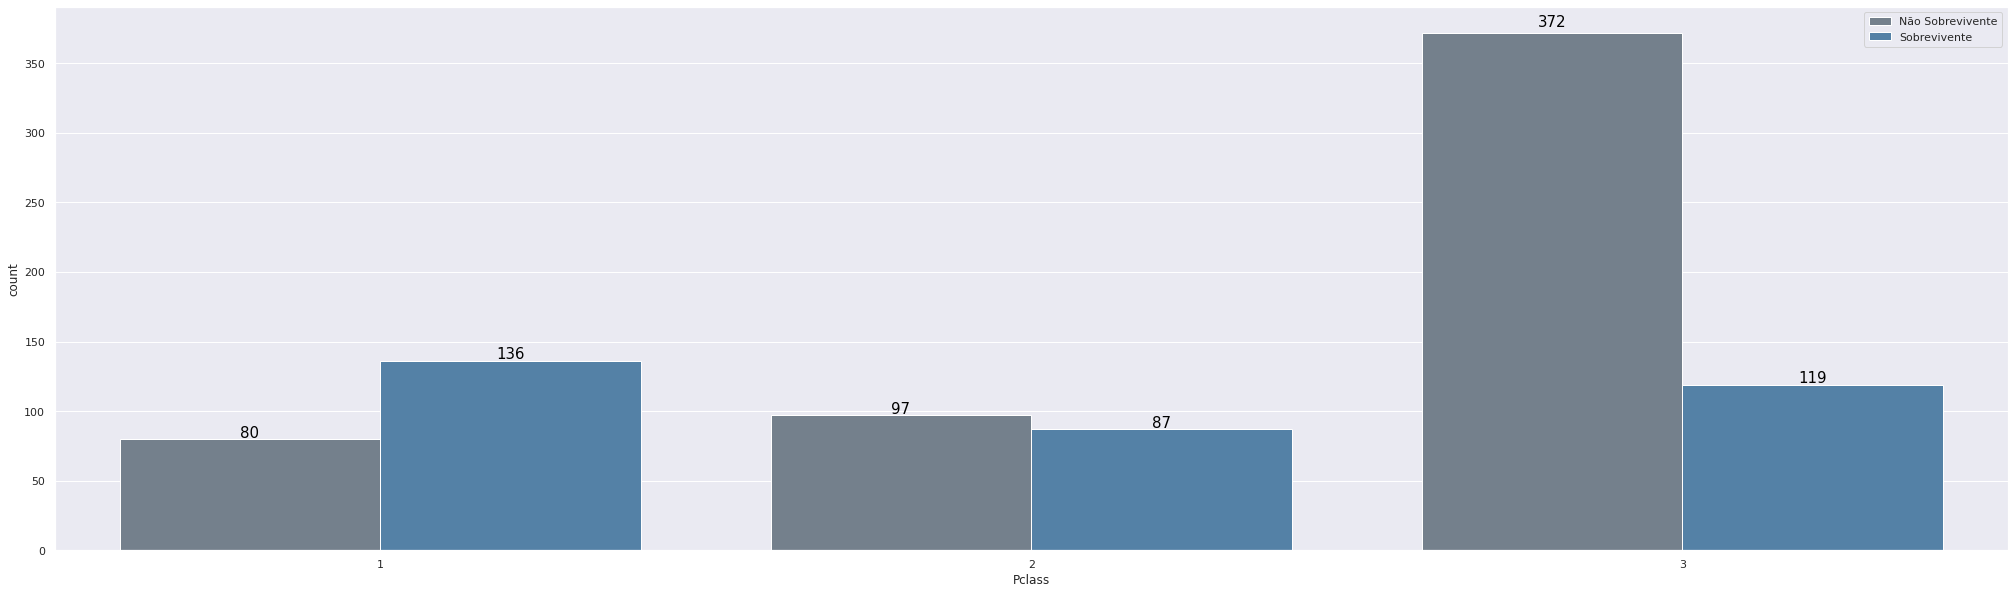

In [73]:
ax = sns.countplot(
    data    = data_raw,
    x       = 'Pclass',
    hue     = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
graph.plot_values_vbar( ax )

### Sex x Survived

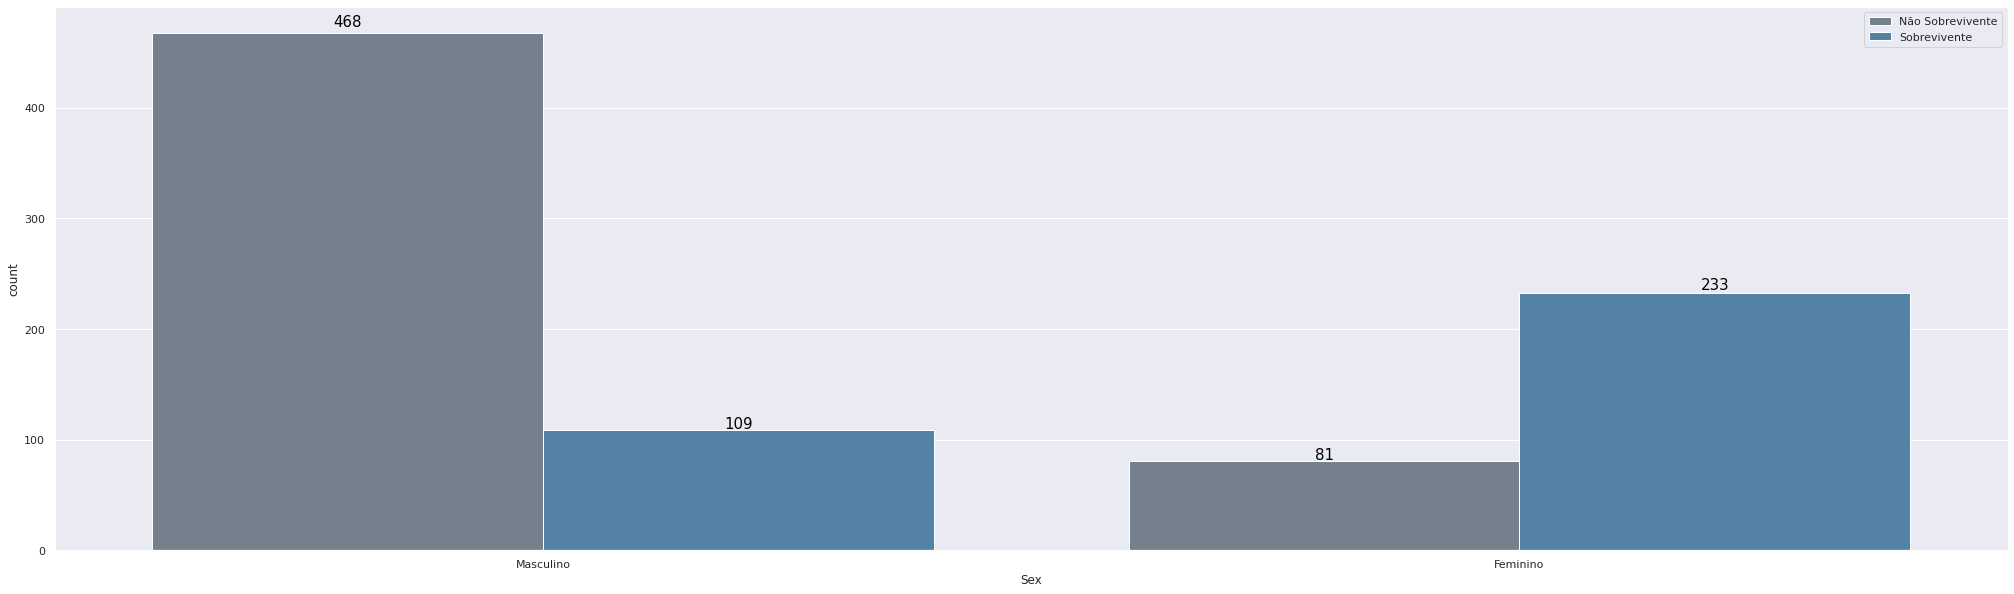

In [74]:
ax = sns.countplot(
    data = data_raw,
    x    = 'Sex',
    hue  = 'Survived',
    palette = ['slategray', 'steelblue']
);
ax.set_xticklabels( ['Masculino', 'Feminino'] );
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
graph.plot_values_vbar( ax )


In [75]:
numH = data_raw.loc[data_raw.Sex == 0,'Name'].count()
numM = data_raw.loc[data_raw.Sex == 1,'Name'].count()

numSH = data_raw.loc[( data_raw.Sex == 0 ) & (data_raw.Survived == 1),'Name'].count()
numSM = data_raw.loc[( data_raw.Sex == 1 ) & (data_raw.Survived == 1),'Name'].count()


print( f'Homens tinham uma chance de {numSH/numH:.2%} de sobreviver' )
print( f'Mulheres tinham uma chance de {numSM/numM:.2%} de sobreviver' )

Homens tinham uma chance de 18.89% de sobreviver
Mulheres tinham uma chance de 74.20% de sobreviver


### Age x Survived

Deve-se salientar que os gráficos se encontram em escalas diferentes


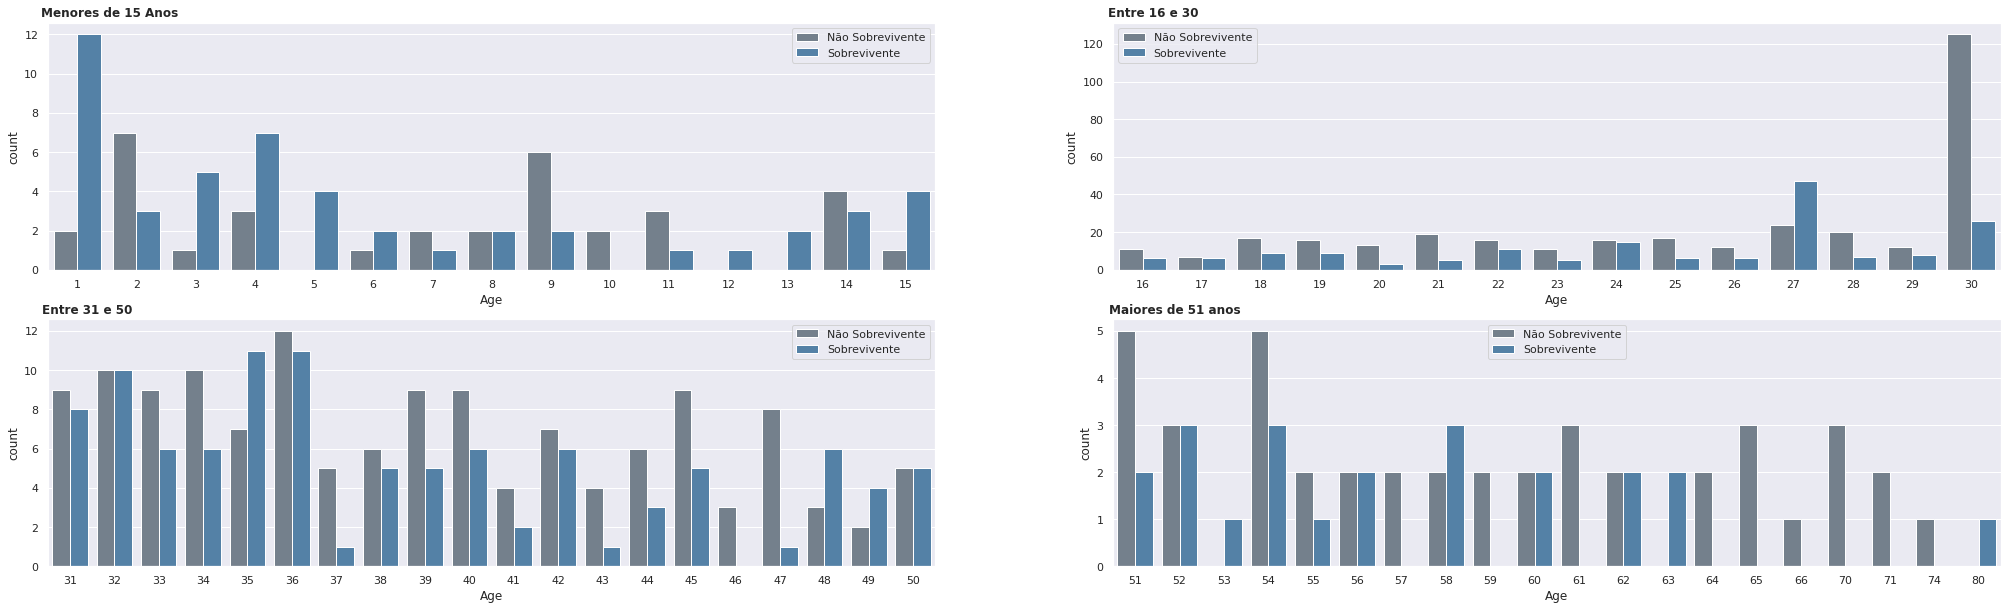

In [76]:
spec = GridSpec(2,2)
#First graph
plt.subplot(spec[0,0])
ax = sns.countplot(
    data = data_raw[data_raw.Age <= 15],
    x = 'Age',
    hue = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
plt.title( 'Menores de 15 Anos', x = 0.07, fontweight="bold"  );

#Second graph
plt.subplot(spec[0,1])
ax = sns.countplot(
    data = data_raw[( data_raw.Age > 15 ) & ( data_raw.Age <= 30 ) ],
    x = 'Age',
    hue = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
plt.title( 'Entre 16 e 30', x = 0.045, fontweight="bold"  );

#Third graph
plt.subplot(spec[1,0])
ax = sns.countplot(
    data = data_raw[( data_raw.Age > 30 ) & ( data_raw.Age <= 50 ) ],
    x = 'Age',
    hue = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
plt.title( 'Entre 31 e 50', x = 0.045, fontweight="bold"  );


#Fourth graph
plt.subplot(spec[1,1])
ax = sns.countplot(
    data = data_raw[( data_raw.Age > 50 )],
    x = 'Age',
    hue = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
plt.title( 'Maiores de 51 anos', x = 0.07, fontweight="bold"  );

print( 'Deve-se salientar que os gráficos se encontram em escalas diferentes' )


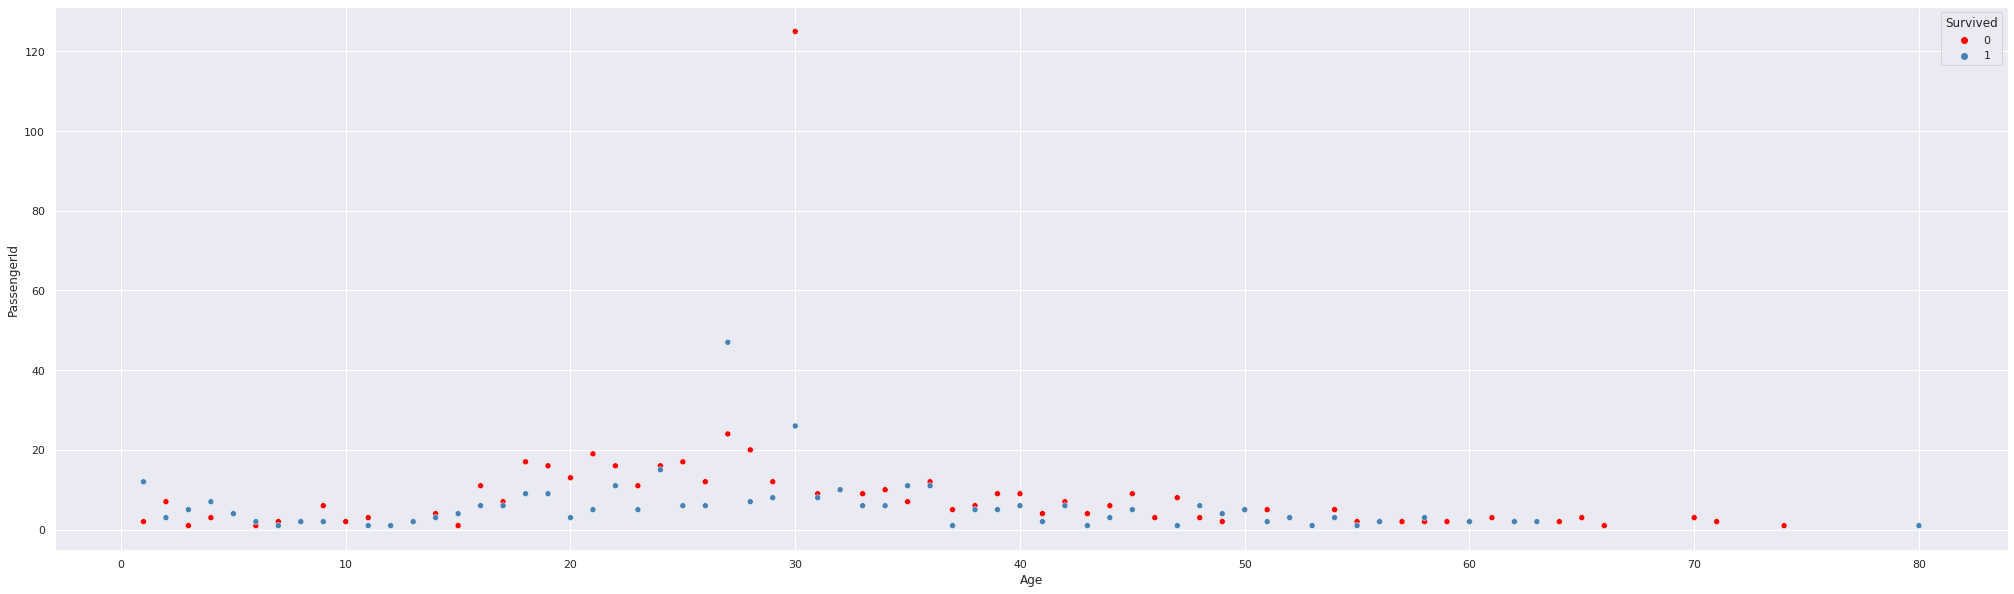

In [77]:
temp = data_raw[['Age', 'Survived','PassengerId']].groupby(['Age','Survived']).count().reset_index()
sns.scatterplot(
    data = temp,
    x = 'Age',
    y = 'PassengerId',
    hue = 'Survived',
    palette = ['red', 'steelblue']
);

### Sibsp x Survived

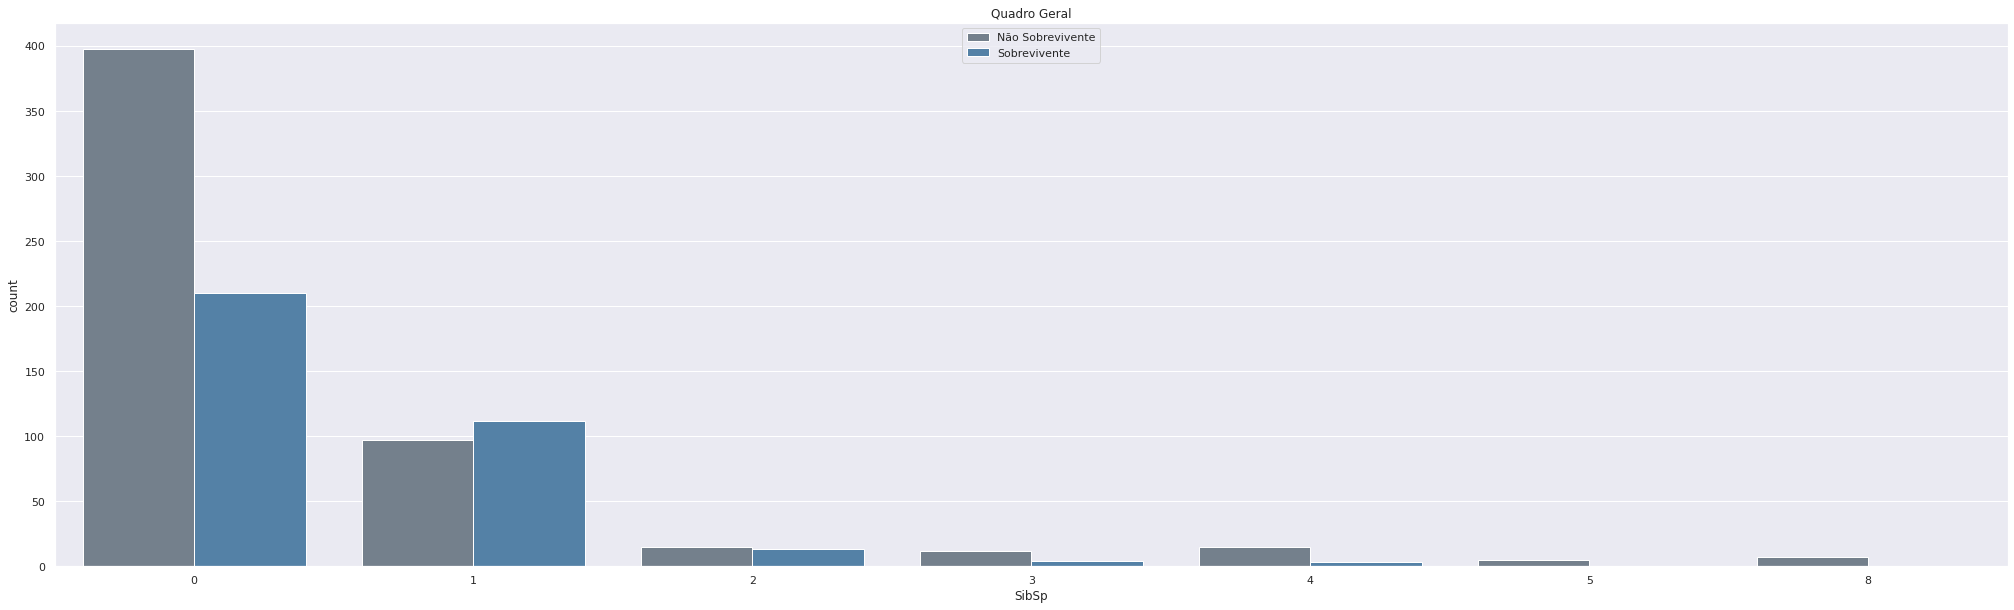

In [78]:
ax = sns.countplot(
    data = data_raw,
    x    = 'SibSp',
    hue  = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
plt.title( 'Quadro Geral' );


### Parch x Survived

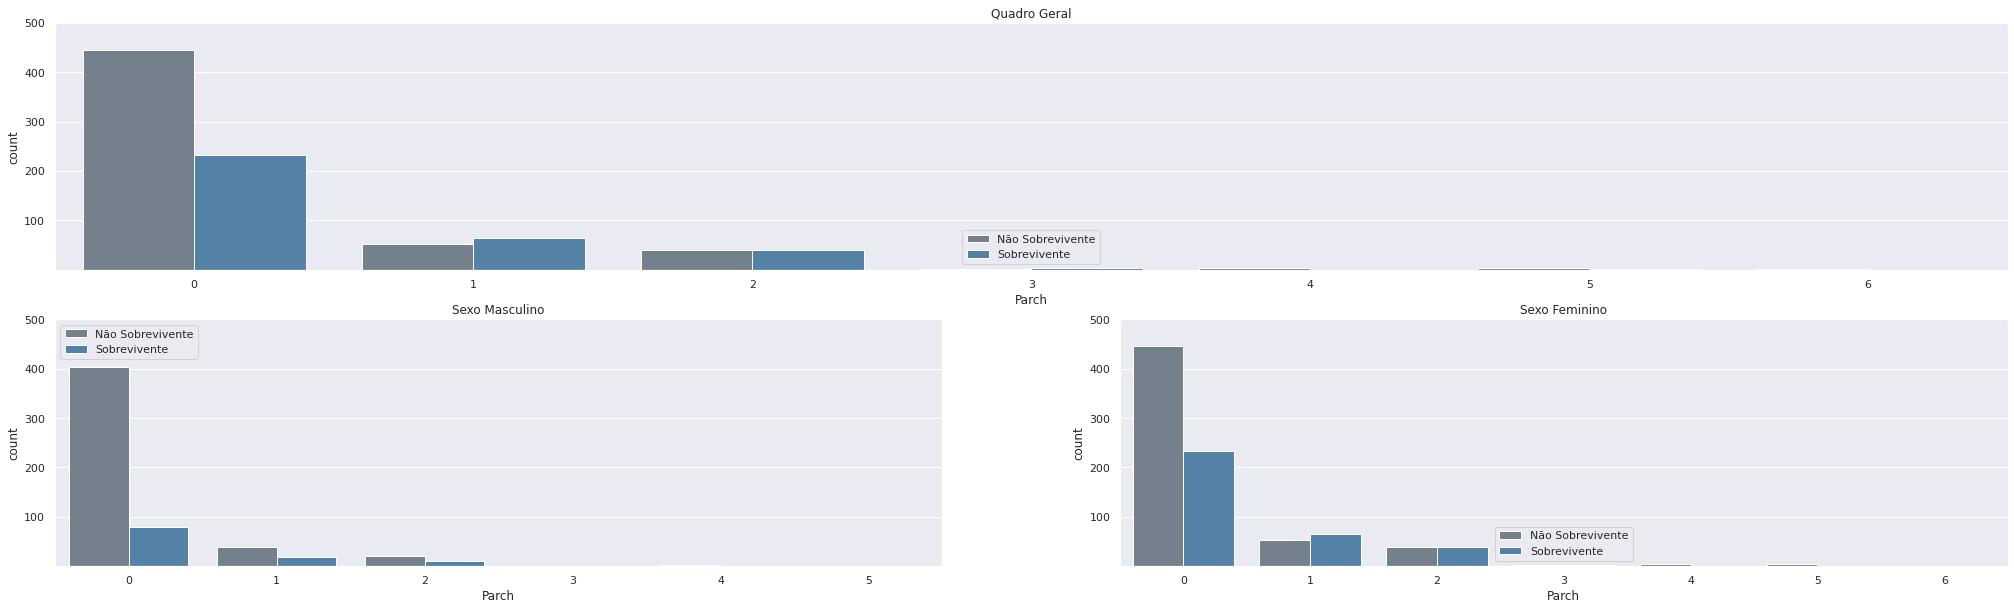

In [79]:
spec = GridSpec(2,2)

#First graph
plt.subplot( spec[0,:] )
sns.countplot(
    data = data_raw,
    x    = 'Parch',
    hue  = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
plt.title( 'Quadro Geral' );
plt.yticks( [100,200,300,400,500] );

#Second graph
plt.subplot( spec[1,0] )
sns.countplot(
    data = data_raw[data_raw.Sex == 0],
    x    = 'Parch',
    hue  = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
plt.title( 'Sexo Masculino' );
plt.yticks( [100,200,300,400,500] );

#Third graph
plt.subplot( spec[1,1] )
sns.countplot(
    data = data_raw,
    x    = 'Parch',
    hue  = 'Survived',
    palette = ['slategray', 'steelblue']
);
plt.legend( ['Não Sobrevivente', 'Sobrevivente'] );
plt.title( 'Sexo Feminino' );
plt.yticks( [100,200,300,400,500] );

### Ticket x Survived

- Análise será realizada em segundo cícolo do CRISP devido a sua complexidade 

### Fare x Survived

- Não se aplica

### Cabin x Survived

- Não se aplica

### Embarked x Survived

- Não se aplica

## 4.5 Correlations

#### Correlações notadas:

#
Pclass
- Tripulantes de primeira classe CLARAMENTE tem um índice de sobrevivência maior. Diminuindo gradativamente com a diminuição da classe econômica; 
#
Sex
- Isoladamente, o sexo é uma das características que mais definem as chances de sobrevivência. Sendo que as mulheres tinham 55.31% a mais de chances de sobreviver que os homens;
#
Age
- Apesar de pouco conclusivo, nota-se alguns picos de sobrevivência (pequena escala em 27 anos) e de óbitos (maior escala em 30 anos);
#
Sibisp
- Denota-se que o nível de sobrevivência de quem não tinha nenhum 'parente' era menor mas volta a cair quando passam de 2;
#
Parch
- Mulheres com 1 parch, tem maior chance de sobrevivência;


#### Heatmap


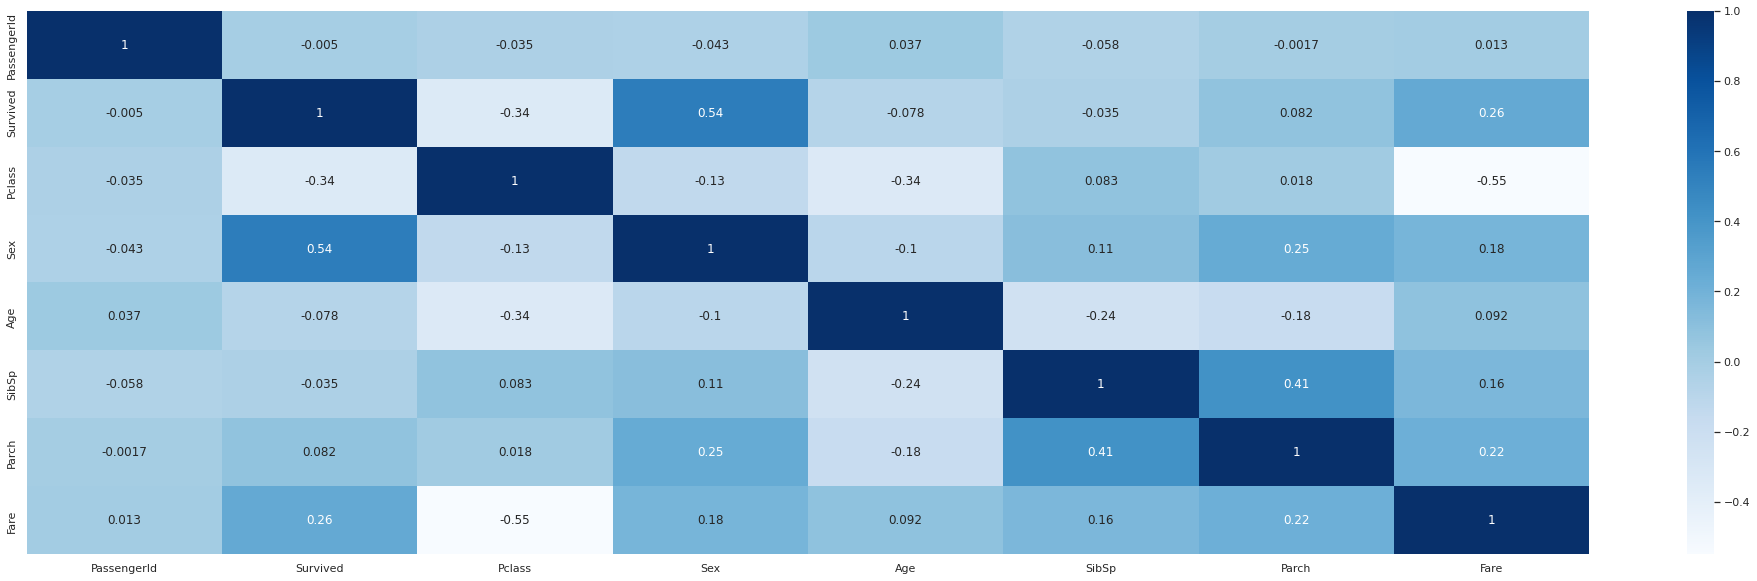

In [80]:
sns.heatmap(
    data_raw.corr( method = 'pearson' ),
    annot = True,
    cmap  = 'Blues'
);

# CHECKPOINT

In [81]:
pkl.dump( data_raw, open( '../data/CP/data_raw1.sav', 'wb' ) )

In [2]:
data_raw = pkl.load( open( '../data/CP/data_raw1.sav', 'rb' ) )

# 5. Feature engineering

### Personal Title (Name)

In [3]:
data_raw['P_title'] = data_raw.Name.apply( lambda x : x[x.find( ',' ) + 2 : x.find( '.' )]  )

# 6 Encoding | Rescaling

### Encoding

#### OneHotEncoding (Dumie)

In [4]:
### P_title
df = pd.get_dummies( data_raw, columns = ['P_title'], prefix = '_' )


###  Rescaling

#### MinMaxScaler

In [5]:
mms_age    = MinMaxScaler()
mms_sibsp  = MinMaxScaler()
mms_parch  = MinMaxScaler()
mms_fare   = MinMaxScaler()
mms_pclass = MinMaxScaler()

#Age
df['Age']   = mms_age.fit_transform( data_raw[['Age']].values )
pkl.dump( mms_age, open( '../models/mms_age.sav', 'wb' ) )
#SibSp
df['SibSp'] = mms_sibsp.fit_transform( data_raw[['SibSp']].values )
pkl.dump( mms_sibsp, open( '../models/mms_sibsp.sav', 'wb' ) ) 
#Parch
df['Parch'] = mms_parch.fit_transform( data_raw[['Parch']].values )
pkl.dump( mms_parch, open( '../models/mms_parch.sav', 'wb' ) )
#Fare
df['Fare']  = mms_fare.fit_transform( data_raw[['Fare']].values )
pkl.dump( mms_fare, open( '../models/mms_fare.sav', 'wb' ) )
#Pclass
df['Pclass']  = mms_pclass.fit_transform( data_raw[['Pclass']].values )
pkl.dump( mms_pclass, open( '../models/mms_pclass.sav', 'wb' ) )



# CHECKPOINT

In [213]:
pkl.dump( df, open( '../data/CP/df.sav', 'wb' ) )

In [2]:
df = pkl.load( open('../data/CP/df.sav', 'rb') )

# 7 Feature selection

### Boruta

In [214]:
x_boruta = df.drop( columns = ['Survived', 'Name', 'Ticket', 'Embarked'] ).values
x_boruta_nm = df.drop( columns = ['Survived', 'Name', 'Ticket', 'Embarked'] )
y_boruta = df.Survived.ravel()

In [ ]:
rf = RandomForestRegressor( n_jobs = -1 )

boruta_select = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=50).fit( x_boruta, y_boruta )

In [216]:
cols_selected = boruta_select.support_.tolist()
cols_selected_boruta = x_boruta_nm.iloc[:,cols_selected].columns.tolist()

In [217]:
cols_selected_boruta

['Sex', 'Fare', '__Mr']

### Extra Tree

In [4]:
x = df.drop( columns = ['PassengerId','Survived', 'Name', 'Ticket', 'Embarked'] )
y = df.Survived

In [5]:
etc = ExtraTreesClassifier( n_jobs = -1 )
etc.fit( x,y )

ExtraTreesClassifier(n_jobs=-1)

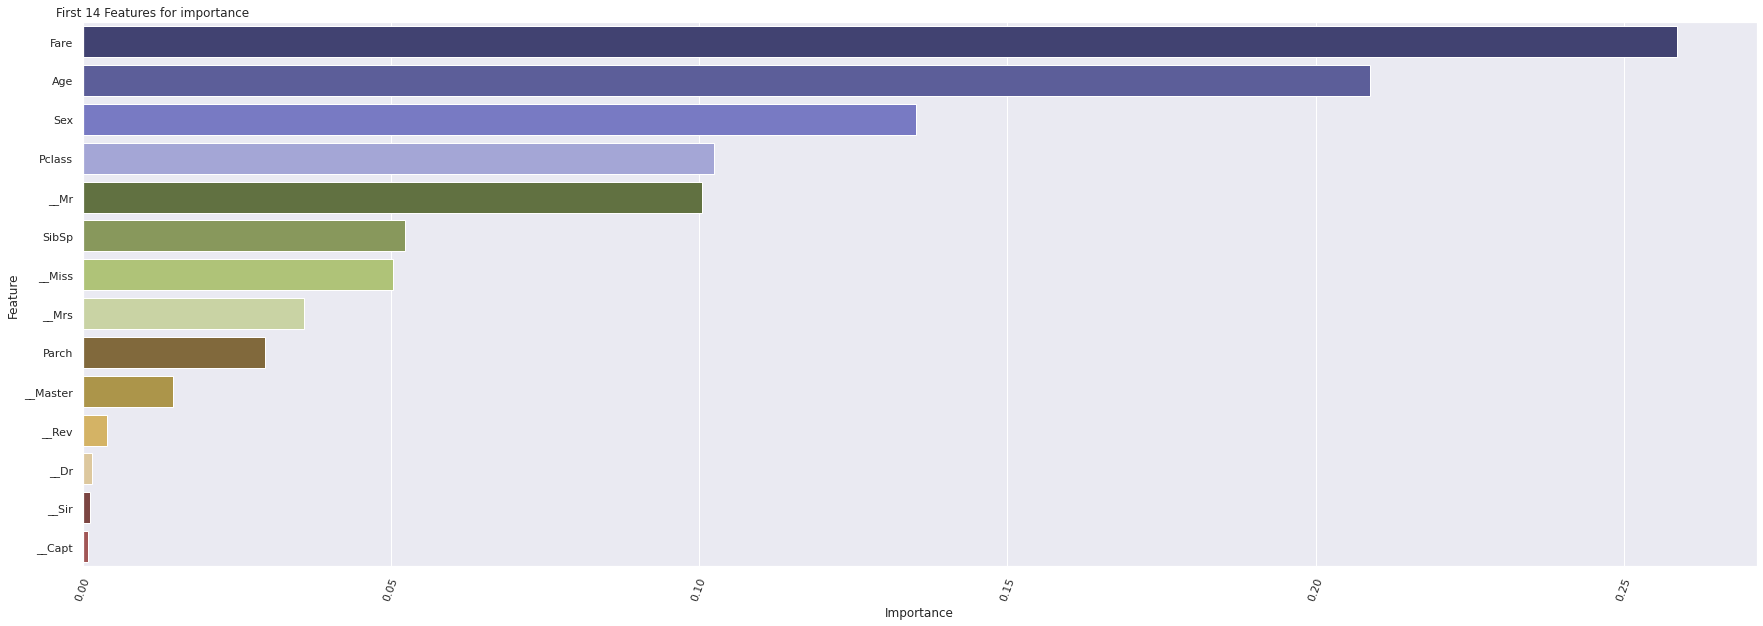

In [55]:
df_aux = pd.DataFrame()
for i, j in zip( x, etc.feature_importances_ ):
    aux = pd.DataFrame( {'Feature' : i, 'Importance' : j}, index=[0] )
    df_aux = pd.concat( [df_aux, aux], axis=0 )
df_aux.sort_values( 'Importance', ascending=False, inplace=True )

sns.set(rc={'figure.figsize':(30,10)})
sns.barplot( 
    data = df_aux.head(14), x = 'Importance', y = 'Feature',
    palette='tab20b'
);
plt.xticks(rotation = 70 )
plt.title( 'First 14 Features for importance', x=0.042 );

In [67]:
df_aux.reset_index (drop = True )
features_selected =list( df_aux.Feature[0:6] )
pkl.dump(features_selected, open( '../models/features_selected.sav', 'wb' ))

# 8. Machine Learning 

## 8.1 Train test split

In [74]:
x = df.drop( columns = ['PassengerId','Survived', 'Name', 'Ticket', 'Embarked'] )
x = x[features_selected]
y = df.Survived

In [75]:
pkl.dump( y, open( '../data/CP/y.sav', 'wb' ) )
pkl.dump( x, open( '../data/CP/x.sav', 'wb' ) )

In [3]:
x = pkl.load( open( '../data/CP/x.sav', 'rb' ) )
y = pkl.load( open( '../data/CP/y.sav', 'rb' ) )

In [4]:
xtr, xte, ytr, yte = train_test_split(x, y, random_state = 42)

## 8.2 Models

### 8.2.1 Teste

#### Random Forest Classifier

In [47]:
#Model train
rfc = RandomForestClassifier()
rfc.fit( xtr, ytr )
#Score
res    = cross_validate( rfc, xte,yte, cv = 5 )
resrf = pd.DataFrame(
    {'Model Name' : 'Random Forest Classifier',
    'CV Score'    : res['test_score'].mean()},
    index = [0]
)


### XGBoost

In [76]:
xgbc = xgb.XGBClassifier()
xgbc.fit( xtr, ytr )
res = cross_validate( xgbc, xte,yte, cv = 5 )
resxgb= pd.DataFrame(
    {'Model Name' : 'XGBoost Classifier',
    'CV Score'    : res['test_score'].mean()},
    index = [0]
)

### Ridge Clasifier

In [48]:
rc    = RidgeClassifierCV()
rc.fit( xtr, ytr )
res   = rc.score( xte, yte )
resrc = pd.DataFrame(
    {'Model Name' : 'Ridge Classifier',
    'CV Score'    : res},
    index = [0]
)

### Logistic RegressionCV

In [54]:
lr    = LogisticRegressionCV()
lr.fit( xtr, ytr )
res   = lr.score( xte, yte )
reslr = pd.DataFrame(
    {'Model Name': 'Logistic Regression',
    'CV Score'   : res},
    index = [0]
)

### Lasso

In [67]:
lss = LassoCV()
lss.fit( xtr, ytr )
res = lss.score( xte, yte )
reslss = pd.DataFrame(
    {'Model Name' : 'Lasso',
    'CV Score'    : res},
    index = [0]
)

### Results

In [5]:
result = modelSelect.scorecv( xtr, ytr, xte, yte )

In [6]:
result

,Model Name,CV Score
0,Random Forest Classifier,0.838485
1,XGBoost Classifier,0.802424
2,Ridge Classifier,0.798206
3,Logistic Regression,0.789238
4,Lasso,0.436718
